# Retake Exam 2024 - Risk based portfolio and

# Guided Solution


Below, I will examplify how to solve the problems. I will not, necessarily, provide the full solution. 

Results may depend on modelling choices. 

# Packages

Imported functions and modules are used for solving the exam.  

In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

In [2]:
from typing import Union 

# numpy for working with matrices, etc. 
import numpy as np

# import pandas
import pandas as pd

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter


# scipy for statistics and optimization 
from scipy import optimize
from scipy import stats

# import cvxpy
import cvxpy as cp

# function to perform interpolation
from scipy.interpolate import interp1d

"""
functions from codelib
"""

# functions for calculating moments
import codelib.statistics.moments as mom
# functions for calculating risk metrics
import codelib.portfolio_optimization.risk_metrics as rm
# functions for risk budgetting
import codelib.portfolio_optimization.risk_budget as rb
# functions for mean-variance optimization
import codelib.portfolio_optimization.mean_variance as mvo

# cash flows
from codelib.fixed_income.cash_flows import CashFlow

# predefined plots
from codelib.visualization.base import fan_chart, waterfall_chart

# Problem 1: Portfolio optimization

Assume that the yearly linear return follows a log-normal distribution. The excel-file _data.xlsx_ contains the expected one year discrete return, the volatility and correlation of the one discrete return, and the yearly cost. 

In [3]:
"""
Load data
"""

# Define asset names and relevant indices
asset_names = pd.read_excel('data.xlsx', sheet_name='expected returns', index_col=0).index.values.flatten()
num_assets = len(asset_names)

asset_indices = {k: i for i, k in enumerate(asset_names)}

# 1y liner return
mu_linear_1y = pd.read_excel('data.xlsx', sheet_name='expected returns', index_col=0).values.flatten()

# 1y linear return correlation matrix
corr_mat_linear_1y = pd.read_excel('data.xlsx', sheet_name='correlation', index_col=0).values
corr_mat_linear_1y[np.tril_indices_from(corr_mat_linear_1y, k=-1)] = corr_mat_linear_1y.T[np.tril_indices_from(corr_mat_linear_1y, k=-1)]

# 1y linear return volatilities
vols_linear_1y = pd.read_excel('data.xlsx', sheet_name='volatilities', index_col=0).values.flatten()
costs_linear_1y = pd.read_excel('data.xlsx', sheet_name='cost', index_col=0).values.flatten()

In [4]:
"""
Calculate covariance matrix of 1y linear returns
"""

cov_mat_linear_1y = mom.corr_to_cov_matrix(corr_mat_linear_1y, vols_linear_1y)

In [5]:
# show covariance matrix
# pd.DataFrame(cov_mat_linear_1y, columns=asset_names, index=asset_names).round(4)

## What is the $\mu$ and $\Sigma$ parameters in the log-normal distribution of the yearly log prices?

We assume the vector of discrete yearly gross returns after cost $1 + R$ follows a log-normal distribution $1 + R \sim \log N(\boldsymbol{\mu}, \boldsymbol{\Sigma})$

We have that 

$$
E[1 + R] = e^{\mu + \frac{1}{2} \text{diag}(\Sigma)}
$$

and 

$$
Cov[1 + R] = (e^{\Sigma} - I) \odot E[1 + R] E[1 + R]^\top
$$

From the latter, we can easily derive that 

$$
\Sigma   = \log ((Cov[1 + R] + E[1 + R] E[1 + R]^\top) \odot \frac{1}{E[1 + R] E[1 + R]^\top}) = \log (1 + Cov[1 + R] \odot \frac{1}{E[1 + R] E[1 + R]^\top})
$$

Knowing $\Sigma$, we can define 

$$
\mu = \log(E[1 + R]) - \frac{1}{2} \text{diag}(\Sigma)
$$

In [6]:
"""
Define function to convert between normal and log-normal parameters
"""

def convert_to_lognormal(mean, cov_mat): 

    cov_mat_log = np.log(1 + cov_mat / np.outer(mean, mean))
    
    mu_log = np.log(mean) - 0.5 * np.diag(cov_mat_log)

    return mu_log, cov_mat_log

In [7]:
"""
Calculate the yearly mu and covariance matrix of log returns
"""

mu_log_1y, cov_mat_log_1y = convert_to_lognormal(mean=1 + mu_linear_1y - costs_linear_1y, cov_mat=cov_mat_linear_1y)
vols_log_1y = np.sqrt(np.diag(cov_mat_log_1y))

In [8]:
# cov_mat_log_1y

In [9]:
# mu_log_1y

### Validate that the obtained parameters are consistent with provided expected returns, volatilities and covariance matrix

In [10]:
# check expectation
np.linalg.norm(mom.calculate_log_norm_mean(mu_log_1y, cov_mat_log_1y) - 1.0 - (mu_linear_1y - costs_linear_1y))

2.4291084510816706e-16

In [11]:
# check covariance matrix
np.linalg.norm(mom.calculate_log_norm_cov_mat(mu_log_1y, cov_mat_log_1y) - cov_mat_linear_1y)

6.449584606598189e-16

In [12]:
"""
Simulation - choose an asset index
"""

asset_idx = 0
num_sim = 100_000

sim_log_norm_1y = stats.lognorm(s=vols_log_1y[asset_idx], scale=np.exp(mu_log_1y[asset_idx])).rvs(num_sim) - 1.0

In [13]:
sim_log_norm_1y.mean()

0.027874044963971122

In [14]:
[mu_linear_1y - costs_linear_1y][asset_idx]

array([0.0277, 0.0307, 0.042 , 0.0426, 0.0631, 0.0769, 0.0877, 0.0637,
       0.0447, 0.0477])

### Weekly parameters

We assume independence between log returns such that we can think of them as market invariants. Since log-returns aggregrate across time, we can simply multiply with the time step. 

In [15]:
"""
Weekly parameters
"""

# time step 
dt = 1.0 / 52.0 

# Calculate weekly parameters of the log-normal distribution
mu_log_weekly, cov_mat_log_weekly = mu_log_1y * dt, cov_mat_log_1y * dt
vols_log_weekly = np.sqrt(np.diag(cov_mat_log_weekly))

In [16]:
# mu_log_weekly

## Simulate the log-returns and prices for the next 5 years

In [17]:
def simulate_price_evolution(initial_values: np.ndarray,
                             mu: np.ndarray, 
                             cov_mat: np.ndarray,
                             num_sim: int, 
                             num_per: int):
    
    # number of risk drivers
    num_risk_drivers = len(mu)
    
    # define matrix to store values
    risk_drivers = np.zeros((num_sim, 1 + num_per, num_risk_drivers))
    risk_drivers[:, 0, :] = np.log(initial_values)
    
    # simulate normal invariants
    eps = stats.multivariate_normal(mean=mu, cov=cov_mat).rvs(size=(num_sim, num_per))
    
    # create risk drives at horizon
    risk_drivers[:, 1:, :] = np.log(initial_values) + np.cumsum(eps, axis=1)
    
    return np.exp(risk_drivers)

In [18]:
def calculate_analytical_percentile(mu: np.ndarray,
                                    vol: np.ndarray, 
                                    horizon=1.0,
                                    q=0.5) -> float: 
    """
    Function calculating the q-percentile of a log-normal asset
    """
    
    if horizon == 0.0:
        return np.ones_like(q)
    else: 
        return stats.lognorm.ppf(q, s=vol * np.sqrt(horizon), scale=np.exp(mu * horizon))

In [19]:
"""
Inputs
"""

num_sim = 100_000
num_per = 52 * 5

"""
Simulate prices
"""
time_points = np.arange(0, 5 + dt, dt)
sim_prices = simulate_price_evolution(np.ones_like(asset_names, dtype=float),
                                      mu_log_weekly,
                                      cov_mat_log_weekly,
                                      num_sim,
                                      num_per)

"""
Store in dict
"""

sim_data = {asset_names[i] : sim_prices[:, :, i] for i in range(num_assets)}

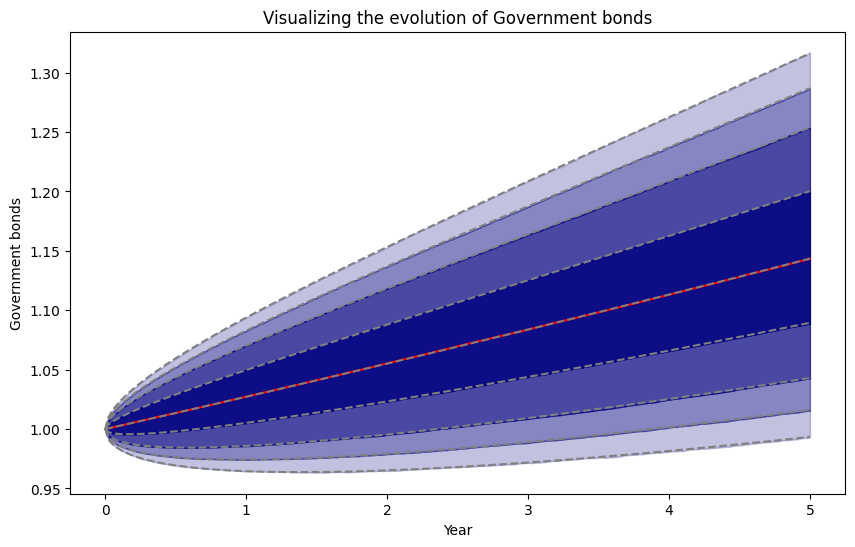

In [20]:
asset_id = 'Government bonds' 
asset_idx = asset_indices[asset_id]

# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data[asset_id], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)
# calculating analytical percentiles
true_percentiles = np.array([calculate_analytical_percentile(mu_log_weekly[asset_idx], vols_log_weekly[asset_idx], t,
                             q=[0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.75 , 0.9  , 0.95 , 0.975]) for t in time_points / dt])

# plotting
fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points, percentiles, ax=ax, color="navy")
ax.plot(time_points, true_percentiles, color="gray", linestyle="--");

ax.set(ylabel=asset_id, xlabel="Year", title="Visualizing the evolution of " + asset_id); 

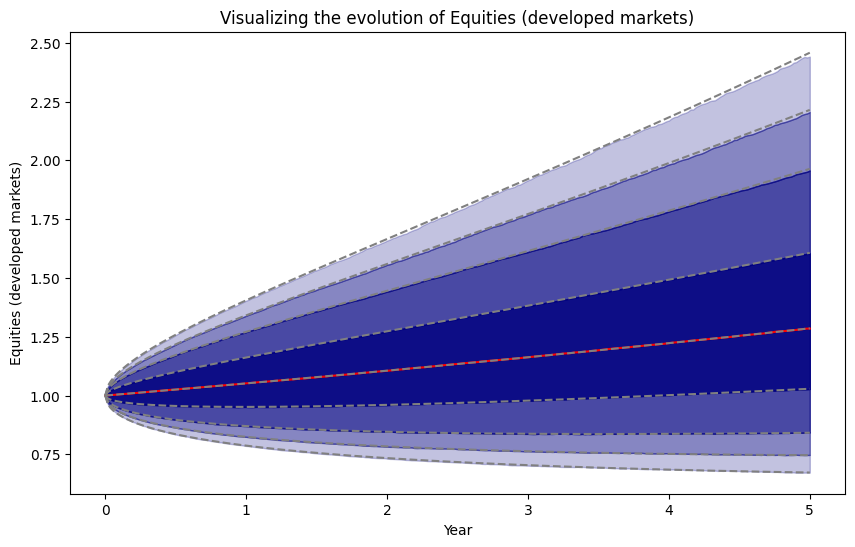

In [21]:
asset_id = 'Equities (developed markets)' 
asset_idx = asset_indices[asset_id]

# calculate simulated percentiles for log-fx
percentiles = np.percentile(sim_data[asset_id], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)
# calculating analytical percentiles
true_percentiles = np.array([calculate_analytical_percentile(mu_log_weekly[asset_idx], vols_log_weekly[asset_idx], t,
                             q=[0.025, 0.05 , 0.1  , 0.25 , 0.5  , 0.75 , 0.9  , 0.95 , 0.975]) for t in time_points / dt])

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points, percentiles, ax=ax, color="navy")
ax.plot(time_points, true_percentiles, color="gray", linestyle="--");

ax.set(ylabel=asset_id, xlabel="Year", title="Visualizing the evolution of " + asset_id); 

## Calculate risk measures for the assets on a weekly and yearly horizon

We provide the mean, standard deviation, skewness, kurtosis (excess), VaR and CVaR. We know that the asset prices follow a log normal distribution, so we can calculate everything analytical. 

In [22]:
def calculate_analytical_metrics(mu, vol, alpha=0.05):
        
    dict = {}
    
    dist = stats.lognorm(s=vol, scale=np.exp(mu), loc=-1)

    mean, var, skew, kurt = dist.stats(moments='mvsk')
    std = np.sqrt(var)

    # Value at Risk
    VaR = -1 * dist.ppf(alpha)

    # Conditional Value at Risk
    CVaR = -((np.exp(mu + vol**2 / 2) * stats.norm.cdf(stats.norm.ppf(alpha) - vol)) / alpha - 1)
    
    return {
        'Expected value': mean,
         'Standard deviation': std,
         'Kurtosis': kurt, 
         'Skewness': skew, 
         'VaR({}%)'.format(alpha*100): VaR, 
         'CVaR({}%)'.format(alpha*100): CVaR, 
         'IR': mean / std}

### Weekly horizon

In [23]:
results_weekly = []

for asset, mu, vol in zip(asset_names, mu_log_weekly, vols_log_weekly): 

    metrics = calculate_analytical_metrics(mu, vol)
    metrics['Asset'] = asset

    results_weekly.append(metrics)

df_metrics_weekly = pd.DataFrame(results_weekly).set_index('Asset')

In [24]:
df_metrics_weekly 

,Expected value,Standard deviation,Kurtosis,Skewness,VaR(5.0%),CVaR(5.0%),IR
Asset,,,,,,,
Government bonds,0.000526,0.004454,0.000317,0.013356,0.006784,0.008628,0.117999
Investment-grade bonds,0.000582,0.007668,0.000940,0.022990,0.011980,0.015135,0.075860
High-yield bonds,0.000792,0.012892,0.002656,0.038648,0.020272,0.025520,0.061394
Emerging markets gov. bonds,0.000803,0.012356,0.002439,0.037039,0.019390,0.024425,0.064957
Equities (developed markets),0.001177,0.020524,0.006727,0.061508,0.032219,0.040445,0.057367
Equities (Emerging markets),0.001426,0.026582,0.011281,0.079652,0.041688,0.052211,0.053636
Private equity,0.001618,0.025830,0.010647,0.077383,0.040293,0.050534,0.062638
Infrastructure,0.001188,0.018970,0.005746,0.056848,0.029704,0.037331,0.062641
Real Estate,0.000841,0.012728,0.002588,0.038153,0.019955,0.025138,0.066101


In [25]:
"""
Check - Covariance matrix and expectation vector 
"""

mu_l_weekly = mom.calculate_log_norm_mean(mu_log_weekly, cov_mat_log_weekly) - 1.0
cov_mat_l_weekly = mom.calculate_log_norm_cov_mat(mu_log_weekly, cov_mat_log_weekly)

In [26]:
mu_l_weekly

array([0.00052559, 0.00058167, 0.0007915 , 0.00080258, 0.00117741,
       0.00142576, 0.00161795, 0.00118827, 0.00084131, 0.0008965 ])

### Yearly horizon

In [27]:
results_1y = []

for asset, mu, vol in zip(asset_names, mu_log_1y, vols_log_1y): 

    metrics = calculate_analytical_metrics(mu, vol)
    metrics['Asset'] = asset

    results_1y.append(metrics)

df_metrics_1y = pd.DataFrame(results_1y).set_index('Asset')

In [28]:
df_metrics_1y

,Expected value,Standard deviation,Kurtosis,Skewness,VaR(5.0%),CVaR(5.0%),IR
Asset,,,,,,,
Government bonds,0.0277,0.033,0.016513,0.096365,0.025661,0.038575,0.839394
Investment-grade bonds,0.0307,0.057,0.049074,0.166076,0.060289,0.081548,0.538596
High-yield bonds,0.0420,0.097,0.139783,0.280077,0.109491,0.142892,0.432990
Emerging markets gov. bonds,0.0426,0.093,0.128259,0.268310,0.102979,0.135269,0.458065
Equities (developed markets),0.0631,0.158,0.360799,0.449149,0.175404,0.223654,0.399367
Equities (Emerging markets),0.0769,0.208,0.618081,0.586646,0.228193,0.285768,0.369712
Private equity,0.0877,0.204,0.581633,0.569252,0.212627,0.269801,0.429902
Infrastructure,0.0637,0.146,0.306795,0.414356,0.158268,0.203973,0.436301
Real Estate,0.0447,0.096,0.136181,0.276453,0.105336,0.138477,0.465625


In [29]:
"""
Covariance matrix and expectation vector 
"""

mu_l_1y = mom.calculate_log_norm_mean(mu_log_1y, cov_mat_log_1y) - 1.0
cov_mat_l_1y = mom.calculate_log_norm_cov_mat(mu_log_1y, cov_mat_log_1y)

## Calculate risk measures for five different portfolios at weekly and yearly horizon

### Define portfolios

In [30]:
candidate_portfolios = {}

"""
Equally weighted portfolio
"""

# define weights
w_eq = np.ones(num_assets) / num_assets

# store in dictionary
candidate_portfolios['Equally weighted'] = w_eq

In [31]:
"""
Minimum variance portfolios
"""

def calculate_min_var_portfolio(cov_mat: np.ndarray): 
        
    # define target variable
    num_assets = cov_mat.shape[0]
    w = cp.Variable(num_assets)
    
    # define constraints
    constraints = [cp.sum(w) == 1.0, w>=0]
    
    # define problem 
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov_mat)), constraints)
    
    # solve
    prob.solve()
    
    if prob.status == 'optimal':
        return w.value
    else:    
        return np.ones(num_assets) * np.nan

# minimum variance portfolio (weekly)
w_min_var_weekly = calculate_min_var_portfolio(cov_mat_l_weekly) 

# minimum variance portfolio (yearly)
w_min_var_1y = calculate_min_var_portfolio(cov_mat_l_1y)

In [32]:
# store in dictionary
candidate_portfolios['Minimum variance'] = w_min_var_1y

In [33]:
"""
Max Sharpe - old
"""

def calculate_max_sharpe_portfolio(mu, cov_mat, rf=0): 

    # negative sharpe ratio
    neg_sharpe_ratio = lambda w: -(mvo.portfolio_mean(w, mu) - rf) / mvo.portfolio_std(w, cov_mat)

    # constraints and bounds
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0.0, 1.0) for _ in range(len(mu))]

    # starting values
    w0 = np.ones(len(mu)) / len(mu)

    # minimize negative sharpe ratio
    res = optimize.minimize(neg_sharpe_ratio, w0, method='SLSQP', bounds=bounds, constraints=constraints)
    
    return res.x

def calculate_mean_var_portfolio(mu: np.ndarray, cov_mat: np.ndarray, target): 
        
    # define target variable
    num_assets = cov_mat.shape[0]
    w = cp.Variable(num_assets)
    
    # define constraints
    constraints = [cp.sum(w) == 1.0, w>=0, w @ mu == target]
    
    # define problem 
    prob = cp.Problem(cp.Minimize(cp.quad_form(w, cov_mat)), constraints)
    
    # solve
    prob.solve()
    
    if prob.status == 'optimal':
        return w.value
    else:    
        return np.ones(num_assets) * np.nan

# low
w_mvo_low = calculate_mean_var_portfolio(mu_l_1y, cov_mat_l_1y, 0.035)
candidate_portfolios['MVO 3.5%'] = w_mvo_low

# medium
w_mvo_medium = calculate_mean_var_portfolio(mu_l_1y, cov_mat_l_1y, 0.045)
candidate_portfolios['MVO 4.5%'] = w_mvo_medium

# high
w_mvo_high = calculate_mean_var_portfolio(mu_l_1y, cov_mat_l_1y, 0.065)
candidate_portfolios['MVO 6.5%'] = w_mvo_high

### Summarize portfolio weights

In [34]:
df_port_weights = pd.DataFrame(candidate_portfolios, 
                               index=asset_names)

In [35]:
df_port_weights.round(3)

,Equally weighted,Minimum variance,MVO 3.5%,MVO 4.5%,MVO 6.5%
Government bonds,0.1,0.822,0.717,0.497,-0.000
Investment-grade bonds,0.1,-0.000,-0.000,-0.000,-0.000
High-yield bonds,0.1,0.000,-0.000,-0.000,-0.000
Emerging markets gov. bonds,0.1,-0.000,-0.000,-0.000,0.144
Equities (developed markets),0.1,0.000,0.000,0.000,0.000
Equities (Emerging markets),0.1,0.000,0.000,0.021,0.054
Private equity,0.1,0.000,0.021,0.118,0.310
Infrastructure,0.1,0.030,0.068,0.142,0.282
Real Estate,0.1,0.090,0.104,0.124,0.155
Hedgefunds,0.1,0.058,0.090,0.097,0.054


### Calculate performance and risk metrics

In [36]:
ret_mat_weekly = sim_prices[:, 1, :] - 1.0
ret_mat_1y = sim_prices[:, 52, :] - 1.0

In [37]:
def calculate_portfolio_metrics(w, mu, cov_mat, ret_mat, asset_names=asset_names, alpha=0.05, use_analytical=False):

    # number of assets
    num_assets = len(w)

    # calculate portfolio return 
    port_ret = ret_mat @ w
    
    # Create data frame
    columns = [("Exposure", "Portfolio weights"),
               ("CVaR(5%)", "Standalone"), ("CVaR(5%)", "RC"), ("CVaR(5%)", "MR"),
               ("Expected return", "Standalone"), ("Expected return", "Contribution"),
               ("Std.", "Standalone"), ("Std.", "RC"), ("Std.", "MR"),
               ("Risk-Return", "RoRAC CVaR(5%)"), ("Risk-Return", "RoRAC Std."), 
               #("Risk-Return", "RoMR CVaR(5%)"), ("Risk-Return", "RoMR Std."), 
               ("Risk-Return", "IR CVaR(5%)"), ("Risk-Return", "IR Std.")] # ("Risk-Return", "DI"), 
    
    multi_index = pd.MultiIndex.from_tuples(columns, names=["Category", "Subcategory"])
    
    df_res = pd.DataFrame(columns=multi_index, index=pd.Index(['Portfolio'] + list(asset_names)))

    # exposure
    df_res.loc[:, ('Exposure','Portfolio weights')] = np.r_[1.0, w]

    # CVaR
    df_res.loc['Portfolio', ("CVaR(5%)", "Standalone")] = -rm.calculate_conditional_value_at_risk(port_ret, p=0.05)
    df_res.loc[asset_names, ("CVaR(5%)", "Standalone")] = [-rm.calculate_conditional_value_at_risk(ret_mat[:, i], p=0.05) for i in range(num_assets)]

    df_res.loc[asset_names, ("CVaR(5%)", "RC")] = -rb.calculate_risk_contributions_cvar(w, ret_mat)
    df_res.loc['Portfolio', ("CVaR(5%)", "RC")] = df_res.loc['Portfolio', ("CVaR(5%)", "Standalone")]
    
    df_res.loc[asset_names, ("CVaR(5%)", "MR")] = -rb.calculate_marginal_risks_cvar(w, ret_mat)

    # expected return 
    if use_analytical: 
        df_res.loc[asset_names, ("Expected return", "Standalone")] = mu
        df_res.loc['Portfolio', ("Expected return", "Standalone")] = w @ mu

        df_res.loc[asset_names, ("Expected return", "Contribution")] = mu * w
        df_res.loc['Portfolio', ("Expected return", "Contribution")] = w @ mu
    else: 
        mean_ret = np.mean(ret_mat, axis=0)
        
        df_res.loc[asset_names, ("Expected return", "Standalone")] = mean_ret
        df_res.loc['Portfolio', ("Expected return", "Standalone")] = np.mean(port_ret)

        df_res.loc[asset_names, ("Expected return", "Contribution")] = mean_ret * w
        df_res.loc['Portfolio', ("Expected return", "Contribution")] = np.mean(port_ret)

    # standard devation
    if use_analytical: 
        df_res.loc[asset_names, ("Std.", "Standalone")] = np.sqrt(np.diag(cov_mat))
        df_res.loc['Portfolio', ("Std.", "Standalone")] = np.sqrt(w @ cov_mat @ w)

        df_res.loc[asset_names, ("Std.", "RC")] = rb.calculate_risk_contributions_std(w, cov_mat)
        df_res.loc['Portfolio', ("Std.", "RC")] = np.sqrt(w @ cov_mat @ w)

        df_res.loc[asset_names, ("Std.", "MR")] = rb.calculate_marginal_risks_std(w, cov_mat)
    
    else: 
        cov_mat_est = np.cov(ret_mat.T)
        
        df_res.loc[asset_names, ("Std.", "Standalone")] = np.sqrt(np.diag(cov_mat_est))
        df_res.loc['Portfolio', ("Std.", "Standalone")] = np.sqrt(w @ cov_mat_est @ w)

        df_res.loc[asset_names, ("Std.", "RC")] = rb.calculate_marginal_risks_std(w, cov_mat_est)
        df_res.loc['Portfolio', ("Std.", "RC")] = np.sqrt(w @ cov_mat_est @ w)

        df_res.loc[asset_names, ("Std.", "MR")] = rb.calculate_risk_contributions_std(w, cov_mat_est)

    # risk-return 
    df_res.loc[:, ("Risk-Return", "RoRAC CVaR(5%)")] = df_res.loc[:, ("Expected return", "Contribution")] / df_res.loc[:, ("CVaR(5%)", "RC")]
    df_res.loc[:, ("Risk-Return", "RoRAC Std.")] = df_res.loc[:, ("Expected return", "Contribution")] / df_res.loc[:, ("Std.", "RC")]

    #df_res.loc[asset_names, ("Risk-Return", "RoMR CVaR(5%)")] = df_res.loc[:, ("Expected return", "Standalone")] / df_res.loc[:, ("CVaR(5%)", "MR")]
    #df_res.loc[asset_names, ("Risk-Return", "RoMR Std.")] = df_res.loc[:, ("Expected return", "Standalone")] / df_res.loc[:, ("Std.", "MR")]
    
    df_res.loc[:, ("Risk-Return", "IR CVaR(5%)")] = df_res.loc[:, ("Expected return", "Standalone")] / df_res.loc[:, ("CVaR(5%)", "Standalone")]
    df_res.loc[:, ("Risk-Return", "IR Std.")] = df_res.loc[:, ("Expected return", "Standalone")] / df_res.loc[:, ("Std.", "Standalone")]

    # df_res.loc[asset_names, ("Expected return", "Contribution")] / df_res.loc[asset_names, ("Expected return", "Contribution")]
    
    return df_res

In [38]:
"""
Equally weighted portfolio
"""

df_port_metrics_eq = calculate_portfolio_metrics(w_eq, mu_l_1y, cov_mat_l_1y, ret_mat_1y, asset_names=asset_names, alpha=0.05, use_analytical=True)
df_port_metrics_eq

Category                              Exposure   CVaR(5%)                      \
Subcategory                  Portfolio weights Standalone        RC        MR   
Portfolio                                  1.0   0.107997  0.107997       NaN   
Government bonds                           0.1   0.038557 -0.002076 -0.020764   
Investment-grade bonds                     0.1   0.081685  0.002576  0.025764   
High-yield bonds                           0.1   0.143671   0.01122  0.112199   
Emerging markets gov. bonds                0.1   0.134909  0.008331  0.083309   
Equities (developed markets)               0.1   0.224588  0.018803  0.188031   
Equities (Emerging markets)                0.1   0.285777  0.023744  0.237436   
Private equity                             0.1   0.269927  0.020674  0.206739   
Infrastructure                             0.1   0.204896  0.010711  0.107113   
Real Estate                                0.1    0.13763  0.004916  0.049162   
Hedgefunds                                 0.1   0.128472  0.009098  0.090983   

Category                     Expected return                    Std.  \
Subcategory                       Standalone Contribution Standalone   
Portfolio                            0.05268      0.05268   0.085656   
Government bonds                      0.0277      0.00277      0.033   
Investment-grade bonds                0.0307      0.00307      0.057   
High-yield bonds                       0.042       0.0042      0.097   
Emerging markets gov. bonds           0.0426      0.00426      0.093   
Equities (developed markets)          0.0631      0.00631      0.158   
Equities (Emerging markets)           0.0769      0.00769      0.208   
Private equity                        0.0877      0.00877      0.204   
Infrastructure                        0.0637      0.00637      0.146   
Real Estate                           0.0447      0.00447      0.096   
Hedgefunds                            0.0477      0.00477      0.092   

Category                                            Risk-Return             \
Subcategory                         RC        MR RoRAC CVaR(5%) RoRAC Std.   
Portfolio                     0.085656       NaN        0.48779   0.615022   
Government bonds              0.000305  0.003051      -1.334018   9.078122   
Investment-grade bonds        0.002681  0.026811       1.191577   1.145042   
High-yield bonds              0.007796  0.077957       0.374336   0.538756   
Emerging markets gov. bonds    0.00639  0.063896        0.51135   0.666708   
Equities (developed markets)  0.013633  0.136334       0.335583   0.462833   
Equities (Emerging markets)     0.0178  0.177997       0.323877    0.43203   
Private equity                0.016445  0.164452       0.424205   0.533287   
Infrastructure                0.008703  0.087032       0.594699   0.731916   
Real Estate                    0.00476  0.047599       0.909238   0.939095   
Hedgefunds                    0.007143  0.071426       0.524271   0.667827   

Category                                            
Subcategory                  IR CVaR(5%)   IR Std.  
Portfolio                        0.48779  0.615022  
Government bonds                0.718414  0.839394  
Investment-grade bonds          0.375832  0.538596  
High-yield bonds                0.292335   0.43299  
Emerging markets gov. bonds     0.315768  0.458065  
Equities (developed markets)    0.280959  0.399367  
Equities (Emerging markets)     0.269091  0.369712  
Private equity                  0.324903  0.429902  
Infrastructure                  0.310889  0.436301  
Real Estate                     0.324783  0.465625  
Hedgefunds                      0.371286  0.518478

In [39]:
"""
Minimum variance portfolio
"""

df_port_metrics_min_var = calculate_portfolio_metrics(w_min_var_1y, mu_l_1y, cov_mat_l_1y, ret_mat_1y, asset_names=asset_names, alpha=0.05, use_analytical=True)
df_port_metrics_min_var

Category                              Exposure   CVaR(5%)                      \
Subcategory                  Portfolio weights Standalone        RC        MR   
Portfolio                                  1.0   0.027074  0.027074       NaN   
Government bonds                      0.821695   0.038557  0.025473     0.031   
Investment-grade bonds                    -0.0   0.081685      -0.0  0.044202   
High-yield bonds                           0.0   0.143671       0.0  0.043424   
Emerging markets gov. bonds               -0.0   0.134909      -0.0  0.058414   
Equities (developed markets)               0.0   0.224588       0.0   0.03134   
Equities (Emerging markets)                0.0   0.285777       0.0  0.035095   
Private equity                             0.0   0.269927      -0.0  -0.00518   
Infrastructure                        0.029702   0.204896 -0.000088  -0.00296   
Real Estate                           0.090394    0.13763  0.001069  0.011821   
Hedgefunds                            0.058209   0.128472  0.000621  0.010669   

Category                     Expected return                    Std.  \
Subcategory                       Standalone Contribution Standalone   
Portfolio                            0.03147      0.03147   0.029187   
Government bonds                      0.0277     0.022761      0.033   
Investment-grade bonds                0.0307         -0.0      0.057   
High-yield bonds                       0.042          0.0      0.097   
Emerging markets gov. bonds           0.0426         -0.0      0.093   
Equities (developed markets)          0.0631          0.0      0.158   
Equities (Emerging markets)           0.0769          0.0      0.208   
Private equity                        0.0877          0.0      0.204   
Infrastructure                        0.0637     0.001892      0.146   
Real Estate                           0.0447     0.004041      0.096   
Hedgefunds                            0.0477     0.002777      0.092   

Category                                            Risk-Return             \
Subcategory                         RC        MR RoRAC CVaR(5%) RoRAC Std.   
Portfolio                     0.029187       NaN       1.162354   1.078226   
Government bonds              0.023983  0.029187       0.893537   0.949054   
Investment-grade bonds            -0.0  0.037452       0.694547   0.819707   
High-yield bonds                   0.0  0.043119       0.967209   0.974055   
Emerging markets gov. bonds       -0.0  0.051386       0.729278   0.829021   
Equities (developed markets)       0.0  0.048474       2.013385   1.301742   
Equities (Emerging markets)        0.0  0.057629       2.191172   1.334397   
Private equity                     0.0  0.042921     -16.931252   2.043265   
Infrastructure                0.000867  0.029187     -21.520096   2.182481   
Real Estate                   0.002638  0.029187       3.781466   1.531506   
Hedgefunds                    0.001699  0.029187       4.470997   1.634291   

Category                                            
Subcategory                  IR CVaR(5%)   IR Std.  
Portfolio                       1.162354  1.078226  
Government bonds                0.718414  0.839394  
Investment-grade bonds          0.375832  0.538596  
High-yield bonds                0.292335   0.43299  
Emerging markets gov. bonds     0.315768  0.458065  
Equities (developed markets)    0.280959  0.399367  
Equities (Emerging markets)     0.269091  0.369712  
Private equity                  0.324903  0.429902  
Infrastructure                  0.310889  0.436301  
Real Estate                     0.324783  0.465625  
Hedgefunds                      0.371286  0.518478

In [40]:
df_port_metrics_low = calculate_portfolio_metrics(w_mvo_low, mu_l_1y, cov_mat_l_1y, ret_mat_1y, asset_names=asset_names, alpha=0.05, use_analytical=True)
df_port_metrics_low

Category                              Exposure   CVaR(5%)                      \
Subcategory                  Portfolio weights Standalone        RC        MR   
Portfolio                                  1.0   0.028222  0.028222       NaN   
Government bonds                      0.716873   0.038557  0.013134  0.018322   
Investment-grade bonds                    -0.0   0.081685      -0.0  0.040309   
High-yield bonds                          -0.0   0.143671      -0.0  0.069647   
Emerging markets gov. bonds               -0.0   0.134909      -0.0  0.066293   
Equities (developed markets)               0.0   0.224588       0.0   0.09228   
Equities (Emerging markets)                0.0   0.285777       0.0  0.109056   
Private equity                        0.021361   0.269927  0.002082  0.097452   
Infrastructure                        0.068404   0.204896  0.004666  0.068206   
Real Estate                           0.103815    0.13763  0.004133  0.039812   
Hedgefunds                            0.089548   0.128472  0.004207  0.046985   

Category                     Expected return                    Std.  \
Subcategory                       Standalone Contribution Standalone   
Portfolio                              0.035        0.035   0.031784   
Government bonds                      0.0277     0.019857      0.033   
Investment-grade bonds                0.0307         -0.0      0.057   
High-yield bonds                       0.042         -0.0      0.097   
Emerging markets gov. bonds           0.0426         -0.0      0.093   
Equities (developed markets)          0.0631          0.0      0.158   
Equities (Emerging markets)           0.0769          0.0      0.208   
Private equity                        0.0877     0.001873      0.204   
Infrastructure                        0.0637     0.004357      0.146   
Real Estate                           0.0447     0.004641      0.096   
Hedgefunds                            0.0477     0.004271      0.092   

Category                                            Risk-Return             \
Subcategory                         RC        MR RoRAC CVaR(5%) RoRAC Std.   
Portfolio                     0.031784       NaN       1.240167   1.101175   
Government bonds              0.015798  0.022038       1.511869   1.256941   
Investment-grade bonds            -0.0  0.035028       0.761624   0.876432   
High-yield bonds                  -0.0   0.05749       0.603038   0.730563   
Emerging markets gov. bonds       -0.0  0.055242       0.642598   0.771152   
Equities (developed markets)       0.0  0.083506       0.683788   0.755637   
Equities (Emerging markets)        0.0  0.100558       0.705145   0.764734   
Private equity                0.002182  0.102147       0.899933   0.858569   
Infrastructure                0.004795  0.070103       0.933938   0.908662   
Real Estate                   0.004644  0.044735       1.122771   0.999213   
Hedgefunds                    0.004365  0.048741       1.015222   0.978649   

Category                                            
Subcategory                  IR CVaR(5%)   IR Std.  
Portfolio                       1.240167  1.101175  
Government bonds                0.718414  0.839394  
Investment-grade bonds          0.375832  0.538596  
High-yield bonds                0.292335   0.43299  
Emerging markets gov. bonds     0.315768  0.458065  
Equities (developed markets)    0.280959  0.399367  
Equities (Emerging markets)     0.269091  0.369712  
Private equity                  0.324903  0.429902  
Infrastructure                  0.310889  0.436301  
Real Estate                     0.324783  0.465625  
Hedgefunds                      0.371286  0.518478

In [41]:
df_port_metrics_medium = calculate_portfolio_metrics(w_mvo_medium, mu_l_1y, cov_mat_l_1y, ret_mat_1y, asset_names=asset_names, alpha=0.05, use_analytical=True)
df_port_metrics_medium

Category                              Exposure   CVaR(5%)                      \
Subcategory                  Portfolio weights Standalone        RC        MR   
Portfolio                                  1.0    0.05719   0.05719       NaN   
Government bonds                      0.497461   0.038557 -0.005302 -0.010657   
Investment-grade bonds                    -0.0   0.081685      -0.0  0.019246   
High-yield bonds                          -0.0   0.143671      -0.0  0.083143   
Emerging markets gov. bonds               -0.0   0.134909      -0.0  0.054807   
Equities (developed markets)               0.0   0.224588       0.0  0.149478   
Equities (Emerging markets)           0.021039   0.285777  0.003792  0.180233   
Private equity                        0.118162   0.269927  0.025184  0.213131   
Infrastructure                        0.142449   0.204896  0.019271  0.135287   
Real Estate                           0.123601    0.13763  0.007244  0.058604   
Hedgefunds                            0.097288   0.128472  0.007001   0.07196   

Category                     Expected return                    Std.  \
Subcategory                       Standalone Contribution Standalone   
Portfolio                              0.045        0.045   0.054173   
Government bonds                      0.0277      0.01378      0.033   
Investment-grade bonds                0.0307         -0.0      0.057   
High-yield bonds                       0.042         -0.0      0.097   
Emerging markets gov. bonds           0.0426         -0.0      0.093   
Equities (developed markets)          0.0631          0.0      0.158   
Equities (Emerging markets)           0.0769     0.001618      0.208   
Private equity                        0.0877     0.010363      0.204   
Infrastructure                        0.0637     0.009074      0.146   
Real Estate                           0.0447     0.005525      0.096   
Hedgefunds                            0.0477     0.004641      0.092   

Category                                            Risk-Return             \
Subcategory                         RC        MR RoRAC CVaR(5%) RoRAC Std.   
Portfolio                     0.054173       NaN       0.786846   0.830678   
Government bonds              0.003254  0.006542      -2.599196   4.234159   
Investment-grade bonds            -0.0   0.02308       1.595096   1.330163   
High-yield bonds                  -0.0  0.063047       0.505152    0.66617   
Emerging markets gov. bonds       -0.0  0.047844       0.777277   0.890394   
Equities (developed markets)       0.0  0.114528       0.422137   0.550958   
Equities (Emerging markets)   0.002988     0.142       0.426669   0.541549   
Private equity                0.020293  0.171735       0.411484   0.510671   
Infrastructure                0.015051  0.105658       0.470852    0.60289   
Real Estate                   0.006594  0.053347       0.762742   0.837916   
Hedgefunds                    0.005994  0.061606       0.662866   0.774272   

Category                                            
Subcategory                  IR CVaR(5%)   IR Std.  
Portfolio                       0.786846  0.830678  
Government bonds                0.718414  0.839394  
Investment-grade bonds          0.375832  0.538596  
High-yield bonds                0.292335   0.43299  
Emerging markets gov. bonds     0.315768  0.458065  
Equities (developed markets)    0.280959  0.399367  
Equities (Emerging markets)     0.269091  0.369712  
Private equity                  0.324903  0.429902  
Infrastructure                  0.310889  0.436301  
Real Estate                     0.324783  0.465625  
Hedgefunds                      0.371286  0.518478

In [42]:
df_port_metrics_high = calculate_portfolio_metrics(w_mvo_high, mu_l_1y, cov_mat_l_1y, ret_mat_1y, asset_names=asset_names, alpha=0.05, use_analytical=True)
df_port_metrics_high

Category                              Exposure   CVaR(5%)                      \
Subcategory                  Portfolio weights Standalone        RC        MR   
Portfolio                                  1.0   0.145974  0.145974       NaN   
Government bonds                          -0.0   0.038557       0.0  -0.03152   
Investment-grade bonds                    -0.0   0.081685      -0.0  0.001964   
High-yield bonds                          -0.0   0.143671      -0.0  0.080333   
Emerging markets gov. bonds           0.143989   0.134909  0.006812  0.047309   
Equities (developed markets)               0.0   0.224588       0.0  0.156456   
Equities (Emerging markets)           0.054153   0.285777  0.010914  0.201537   
Private equity                        0.309949   0.269927  0.073714  0.237826   
Infrastructure                        0.282499   0.204896  0.041928  0.148419   
Real Estate                           0.154958    0.13763  0.008764  0.056559   
Hedgefunds                            0.054451   0.128472  0.003841  0.070547   

Category                     Expected return                    Std.  \
Subcategory                       Standalone Contribution Standalone   
Portfolio                              0.065        0.065   0.114113   
Government bonds                      0.0277         -0.0      0.033   
Investment-grade bonds                0.0307         -0.0      0.057   
High-yield bonds                       0.042         -0.0      0.097   
Emerging markets gov. bonds           0.0426     0.006134      0.093   
Equities (developed markets)          0.0631          0.0      0.158   
Equities (Emerging markets)           0.0769     0.004164      0.208   
Private equity                        0.0877     0.027183      0.204   
Infrastructure                        0.0637     0.017995      0.146   
Real Estate                           0.0447     0.006927      0.096   
Hedgefunds                            0.0477     0.002597      0.092   

Category                                            Risk-Return             \
Subcategory                         RC        MR RoRAC CVaR(5%) RoRAC Std.   
Portfolio                     0.114113       NaN       0.445286   0.569612   
Government bonds                   0.0 -0.001902      -0.878811 -14.560101   
Investment-grade bonds            -0.0  0.015572      15.627776   1.971498   
High-yield bonds                  -0.0  0.060959       0.522822   0.688989   
Emerging markets gov. bonds   0.006334  0.043988       0.900454   0.968456   
Equities (developed markets)       0.0  0.117408       0.403308   0.537442   
Equities (Emerging markets)   0.008197  0.151367       0.381568   0.508037   
Private equity                0.057396  0.185177       0.368756     0.4736   
Infrastructure                0.031087  0.110043       0.429191   0.578865   
Real Estate                   0.007835  0.050562       0.790331   0.884067   
Hedgefunds                    0.003265  0.059954       0.676149   0.795616   

Category                                            
Subcategory                  IR CVaR(5%)   IR Std.  
Portfolio                       0.445286  0.569612  
Government bonds                0.718414  0.839394  
Investment-grade bonds          0.375832  0.538596  
High-yield bonds                0.292335   0.43299  
Emerging markets gov. bonds     0.315768  0.458065  
Equities (developed markets)    0.280959  0.399367  
Equities (Emerging markets)     0.269091  0.369712  
Private equity                  0.324903  0.429902  
Infrastructure                  0.310889  0.436301  
Real Estate                     0.324783  0.465625  
Hedgefunds                      0.371286  0.518478

### Plots for visualization  of risk contribution

In [43]:
w_to_plot = candidate_portfolios['Equally weighted']

#### Standard deviation

In [44]:
rc_std = rb.calculate_risk_contributions_std(w_to_plot, cov_mat_linear_1y)

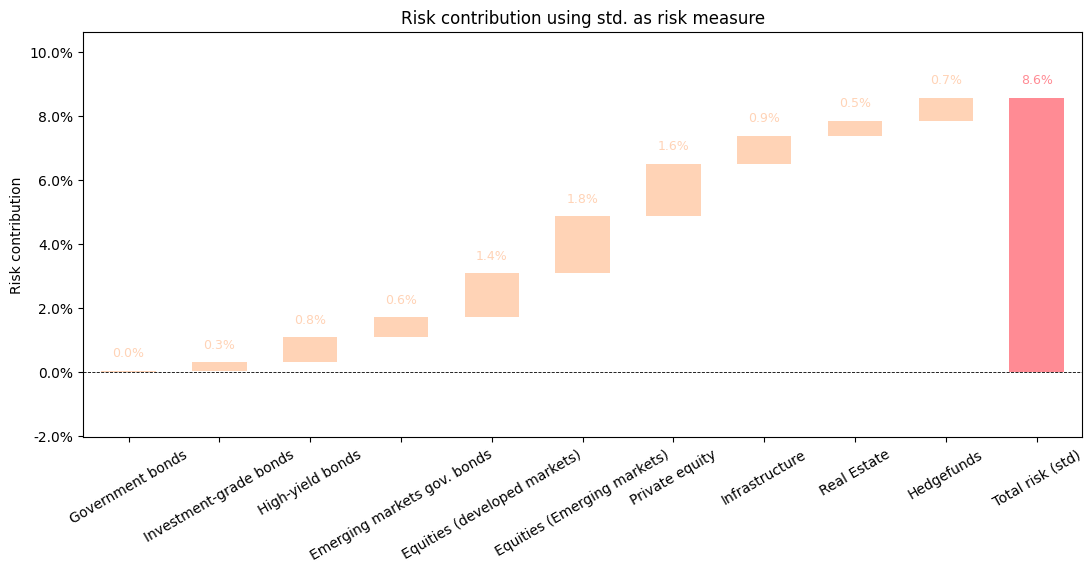

In [45]:
fig, ax = waterfall_chart(values=rc_std*100,
                          labels=asset_names,
                          formatting='{:,.1f}%',
                          total_label="Total risk (std)")

ax.set(ylabel="Risk contribution", title="Risk contribution using std. as risk measure")

fig.set_size_inches(12, 6);

#### Conditional Value at Risk

In [46]:
rc_cvar = rb.calculate_risk_contributions_cvar(w_to_plot, ret_mat_1y)

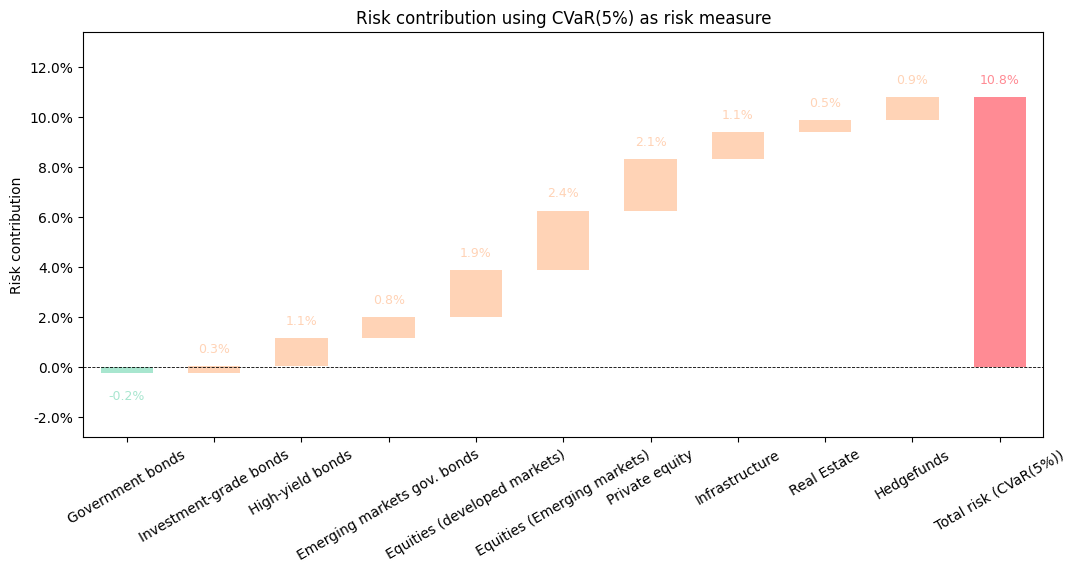

In [47]:
fig, ax = waterfall_chart(values=-rc_cvar*100,
                          labels=asset_names,
                          formatting='{:,.1f}%',
                          total_label="Total risk (CVaR(5%))")

ax.set(ylabel="Risk contribution", title="Risk contribution using CVaR(5%) as risk measure")

fig.set_size_inches(12, 6);

### Select optimal portfolio

In [48]:
def calculate_aggregate_portfolio_metrics(portfolios, mu, cov_mat, ret_mat, alpha=0.05, use_analytical=False):


    # Create data frame
    columns = ["Std.",
               "CVaR(5%)",
               "Expected return",
               "IR CVaR(5%)",
               "IR Std."] 

    df_res = pd.DataFrame(columns=columns, index=list(portfolios.keys()))

    for port_name, w in portfolios.items(): 
    
        # number of assets
        num_assets = len(w)
    
        # calculate portfolio return 
        port_ret = ret_mat @ w
    
        # CVaR
        df_res.loc[port_name, "CVaR(5%)"] = -rm.calculate_conditional_value_at_risk(port_ret, p=0.05)

        # expected return 
        if use_analytical: 
            df_res.loc[port_name, "Expected return"] = w @ mu
        else: 
            mean_ret = np.mean(ret_mat, axis=0)
            df_res.loc[port_name, "Expected return"] = w @ mean_ret
    
        # standard devation
        if use_analytical: 
            df_res.loc[port_name, "Std."] = np.sqrt(w @ cov_mat @ w)
        else: 
            cov_mat_est = np.cov(ret_mat.T)
            df_res.loc[port_name, "Std."] = np.sqrt(w @ cov_mat_est @ w)

    df_res.loc[:, "IR CVaR(5%)"] = df_res.loc[:, "Expected return"] / df_res.loc[:, "CVaR(5%)"]
    df_res.loc[:, "IR Std."] = df_res.loc[:, "Expected return"] / df_res.loc[:, "Std."]

    return df_res

In [49]:
"""
Add small table with Expected return, CVaR, Ratio and indicator
"""

df_agg_port_metrics = calculate_aggregate_portfolio_metrics(candidate_portfolios,
                                                            mu_l_1y,
                                                            cov_mat_l_1y,
                                                            ret_mat_1y,
                                                            alpha=0.05,
                                                            use_analytical=True)

In [50]:
df_agg_port_metrics

,Std.,CVaR(5%),Expected return,IR CVaR(5%),IR Std.
Equally weighted,0.085656,0.107997,0.05268,0.48779,0.615022
Minimum variance,0.029187,0.027074,0.03147,1.162354,1.078226
MVO 3.5%,0.031784,0.028222,0.035,1.240167,1.101175
MVO 4.5%,0.054173,0.05719,0.045,0.786846,0.830678
MVO 6.5%,0.114113,0.145974,0.065,0.445286,0.569612


We can consider either the Minimum Variance or the MVO 3.5% portfolio. 

## Simulate 1Y CVaR of portfolio for the next 5 year

We perform the calculation relative to the market value of the portfolio, but with updated weights. 

In [51]:
"""
Select the portfolio
"""

port_name = 'Equally weighted'
w_to_plot = candidate_portfolios[port_name]

In [52]:
"""
Calculate portfolio value 
"""

sim_portfolio_value = sim_prices @ w_to_plot

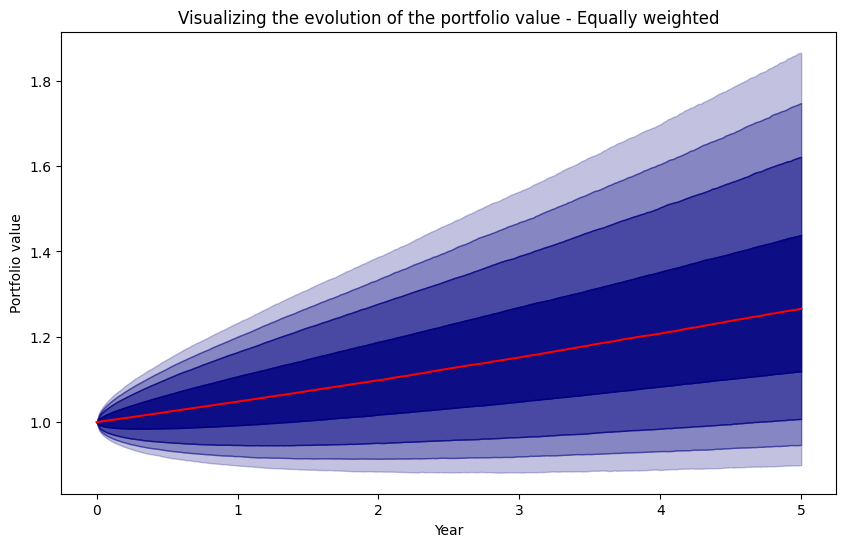

In [53]:
"""
Visualise evolution of portfolio value
"""

percentiles = np.percentile(sim_portfolio_value, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set(ylabel='Portfolio value', xlabel="Year",
       title="Visualizing the evolution of the portfolio value - " + port_name); 

In [54]:
"""
Evolution in portfolio weights
"""

sim_w = sim_prices * w_to_plot[None, None, :] / sim_portfolio_value[:, :, None]


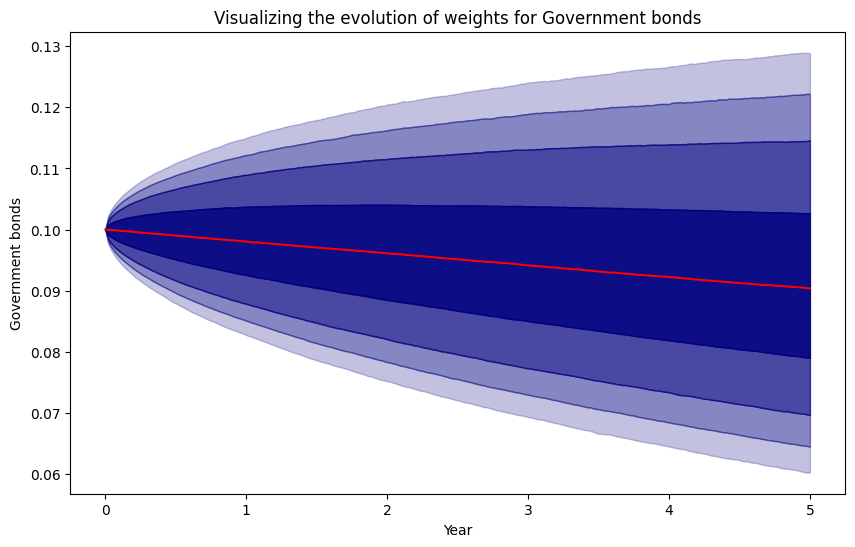

In [55]:
"""
Visualize evolution in portfolio weights
"""

asset_id = 'Government bonds' 
asset_idx = asset_indices[asset_id]

percentiles = np.percentile(sim_w[:, :, asset_idx], [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set(ylabel=asset_id, xlabel="Year", title="Visualizing the evolution of weights for " + asset_id); 

In [56]:
from joblib import Parallel, delayed
# import multiprocessing as mp

In [57]:
"""
Simulate CVaR(5%, 1Y)
"""

horison_in_weeks = 52 * 1
num_sim_to_use = 10_000
sim_cvar = np.zeros((num_sim_to_use, horison_in_weeks + 1))
cvar_time_points = np.arange(0, horison_in_weeks * dt + dt, dt)

#for s in range(num_sim_to_use):
#    for t in range(horison_in_weeks + 1): 
#        sim_cvar[s, t] = -rm.calculate_conditional_value_at_risk(ret_mat_1y @ sim_w[s, t, :], p=0.05)

def compute_simulation_row(s):
    row = np.zeros(horison_in_weeks + 1)
    for t in range(horison_in_weeks + 1):
        row[t] = -rm.calculate_conditional_value_at_risk(ret_mat_1y @ sim_w[s, t, :], p=0.05)
    return row

results = Parallel(n_jobs=-1)(
    delayed(compute_simulation_row)(s) for s in range(num_sim_to_use)
)

sim_cvar = np.array(results)

In [58]:
cvar_time_points = np.arange(0, horison_in_weeks * dt + dt, dt)

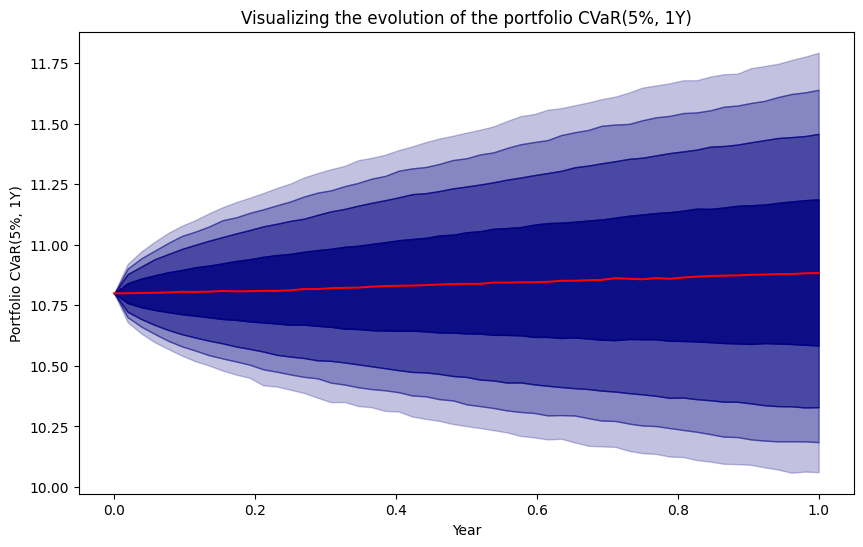

In [59]:
"""
Visualise evolution of portfolio value
"""

percentiles = np.percentile(sim_cvar * 100, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

fan_chart(cvar_time_points, percentiles, ax=ax, color="navy")

ax.set(ylabel='Portfolio CVaR(5%, 1Y)',
       xlabel="Year",
       title="Visualizing the evolution of the portfolio CVaR(5%, 1Y)"); 

## Distribution of realized Sharpe ratios, etc. 

In [60]:
"""
Calculate portfolio period return
"""

sim_port_ret = sim_portfolio_value[:, 1:] / sim_portfolio_value[:, :-1] - 1.0

"""
Calculate relevant metrics
"""

sim_port_std = np.std(sim_port_ret, axis=1)
sim_port_ar_ret = np.mean(sim_port_ret, axis=1)
sim_port_sharpe = sim_port_ar_ret / sim_port_std 
#sim_port_geo_ret = sim_portfolio_value[:, -1]**(1 / 5.0) - 1.0
sim_port_geo_ret = sim_portfolio_value[:, -1]**(1 / (5.0 * 52.0)) - 1.0

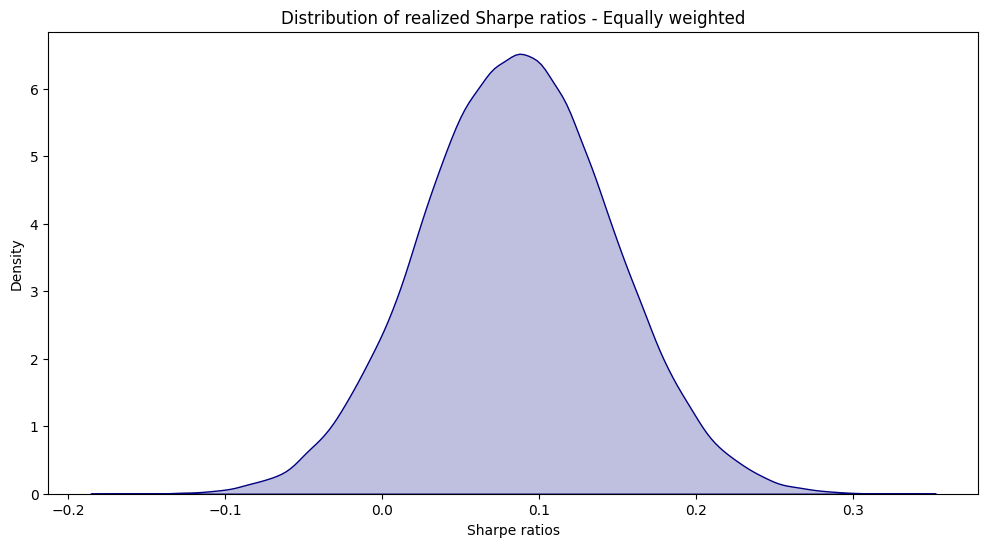

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_port_sharpe, fill=True, color='navy');

ax.set_title('Distribution of realized Sharpe ratios - ' + port_name)
ax.set_xlabel('Sharpe ratios');

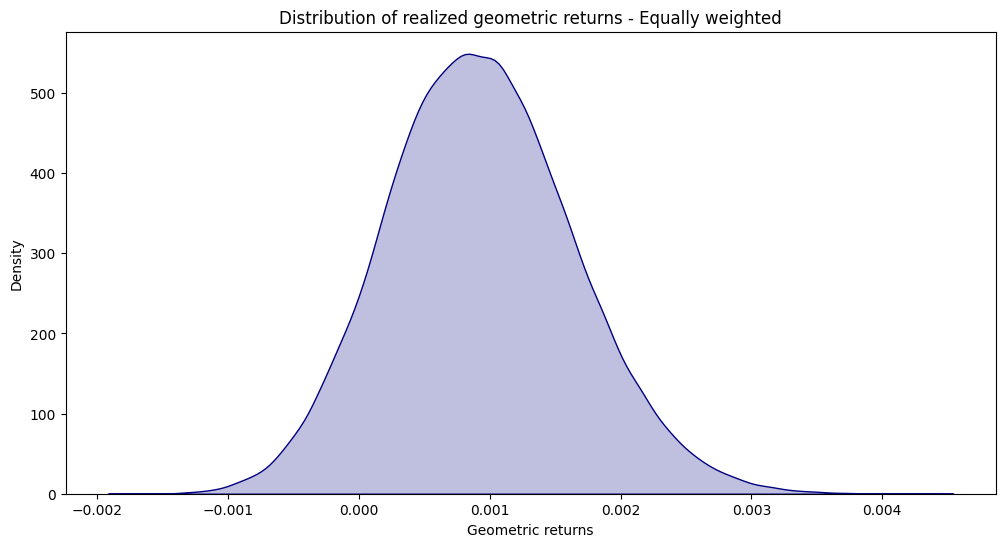

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_port_geo_ret, fill=True, color='navy');
ax.set_title('Distribution of realized geometric returns - ' + port_name)
ax.set_xlabel('Geometric returns');

# Problem 2: Adding an investment to existing portfolio

## Simulate equity prices, short rates and bond prices

### Simulate risk drivers

In [63]:
"""
Initialize parameters for simulation
"""

np.random.seed(222)

# equity parameters
sigma = 0.15
mu = 0.06

# short rate parameters
initial_rate = 0.03
kappa = 1.0
theta = 0.03
beta = 0.02
rp = -0.2

# correlation
rho = -0.2

# simulation definition
num_sim = 10_000
dt = 1.0 / 12.0 
horizon = 5.0 
num_time_steps = int(horizon / dt)
time_points = np.arange(0, num_time_steps + 1, 1) * dt

In [64]:
"""
Define functions for simulation
"""

def simulate_vasicek(initial_short_rate: float, kappa: float, theta: float, beta: float, horizon: float, 
                     dt: float=1.0/12, num_sim: int=10000, z_mat=None):
    """
    simulates short rate processes in a vasicek setting until a given horizon 
    
    Parameters
    ----------
    
    initial_short_rate:
        initial short rate
    kappa: 
        speed of mean reversion.
    theta: 
        long term mean of the short rate.
    dt:
        increments in time
    horizon:
        time until maturity/expiry (horizon).
    num_sim:
        number of simulations.
    """
    std_rates = np.sqrt(beta**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
    
    num_periods = int(horizon / dt)
    short_rates = np.empty((num_sim, num_periods + 1))
    short_rates[:, 0] = initial_short_rate

    if z_mat is None:
        error_terms = np.random.normal(scale=std_rates, size=(num_sim, num_periods))
    else: 
        error_terms = std_rates * z_mat
    
    for i in range(1, num_periods + 1): 
        
        short_rates[:, i] = theta + (short_rates[:, i - 1] - theta) * np.exp(-kappa * dt) + error_terms[:, i - 1]

    return short_rates


def simulate_risk_drivers(mu: float, sigma: float,
                          initial_rate: float, kappa: float, theta: float, beta: float,
                          rho: float,
                          horizon: float, 
                          dt: float=1.0 / 12,
                          num_sim: int=10_000): 
    
    """
    Function simulating the risky asset and the short rate. 
    """

    # define the number of time steps
    num_time_steps = int(horizon / dt)

    # convert parameters of equity values
    mu_scaled = (mu - 0.5 * sigma**2) * dt
    sigma_scaled = sigma * np.sqrt(dt)

    # define innovation correlation matrix
    z_corr_mat = np.array([[1.0, rho], [rho, 1.0]])

    # simulate innovations
    z_mat = np.random.multivariate_normal(np.zeros(2), z_corr_mat, size=(num_sim, num_time_steps))
    
    # simulate equity prices 
    log_ret = mu_scaled + sigma_scaled * z_mat[:, :, 0]
    
    equity_prices = np.ones((num_sim, num_time_steps + 1))
    equity_prices[:, 1:] = np.exp(np.cumsum(log_ret, axis=1))

    # simulate short rates 
    short_rates = simulate_vasicek(initial_short_rate=initial_rate,
                                   kappa=kappa,
                                   theta=theta,
                                   beta=beta,
                                   horizon=horizon, 
                                   dt=dt,
                                   num_sim=num_sim,
                                   z_mat=z_mat[:, :, 1])
    
    return equity_prices, short_rates



In [65]:
"""
Simulate risk drivers
"""

equity_prices, short_rates = simulate_risk_drivers(mu, sigma,
                                                   initial_rate, kappa, theta, beta,
                                                   rho,
                                                   horizon, 
                                                   dt,
                                                   num_sim)

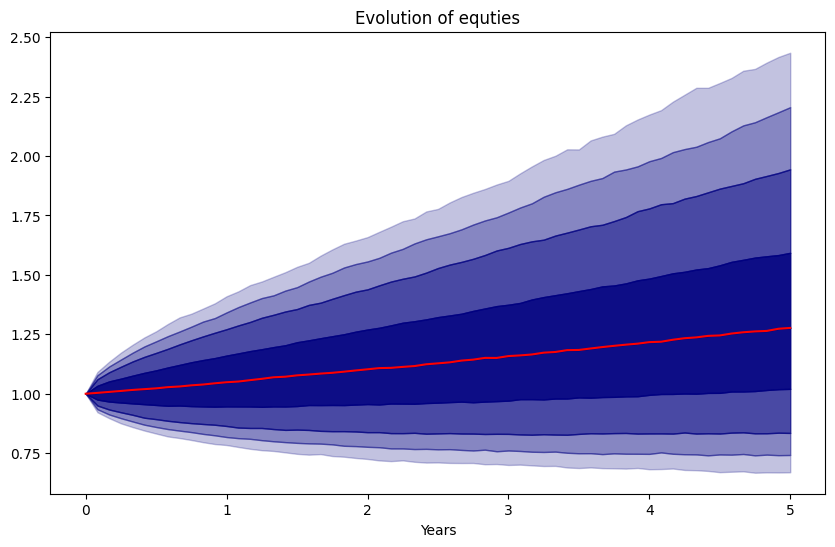

In [66]:
"""
Plot fan chart of short rates
"""
percentiles = np.percentile(equity_prices, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of equties")
ax.set_xlabel('Years');

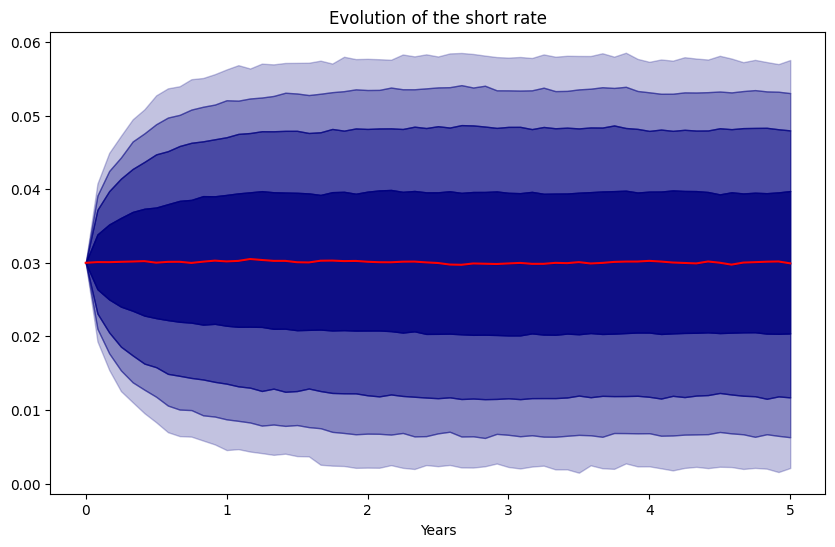

In [67]:
"""
Plot fan chart of short rates
"""
percentiles = np.percentile(short_rates, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of the short rate")
ax.set_xlabel('Years');

### Simulate Zero Coupon bond prices

In [68]:
"""
Define functions for calculating zero coupon bond prices
"""


def calculate_zero_coupon_yield(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float): 
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return (a + b * initial_short_rate) / time_to_maturity

def calculate_zero_coupon_price(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate)

In [69]:
"""
Simulate zero coupon bond prices for maturities 10y and 10y - delta t
"""


zcb_10y_mv = np.zeros((num_sim, num_time_steps + 1))
zcb_10y_minus_delta_t = np.zeros((num_sim, num_time_steps + 1))

for i, t in enumerate(time_points):
    zcb_10y_mv[:, i] = calculate_zero_coupon_price(10.0, short_rates[:, i], kappa, theta, beta, rp)
    zcb_10y_minus_delta_t[:, i] = calculate_zero_coupon_price(10.0 - dt, short_rates[:, i], kappa, theta, beta, rp)

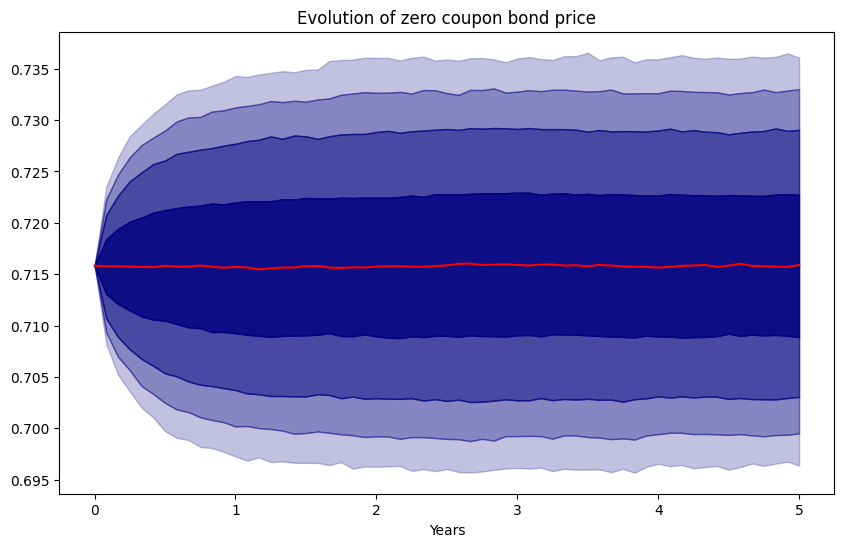

In [70]:
"""
Plot fan chart of zero coupon bond prices
"""
percentiles = np.percentile(zcb_10y_mv, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of zero coupon bond price")
ax.set_xlabel('Years');

### Calculate portfolio value

In [71]:
init_wealth = 100e6
eq_w = 0.6
zcb_w = 0.4

In [72]:
"""
Calculate return of bond and equity
"""
eq_ret = equity_prices[:, 1:] / equity_prices[:, :-1] - 1.0
zcb_ret = zcb_10y_minus_delta_t[:, 1:] / zcb_10y_mv[:, :-1] - 1.0
port_ret = eq_w * eq_ret + zcb_w * zcb_ret

In [73]:
#eq_ret

In [74]:
"""
Calculate portfolio value
"""

port_value = np.c_[init_wealth * np.ones(num_sim), init_wealth * np.cumprod(1 + port_ret, axis=1)]

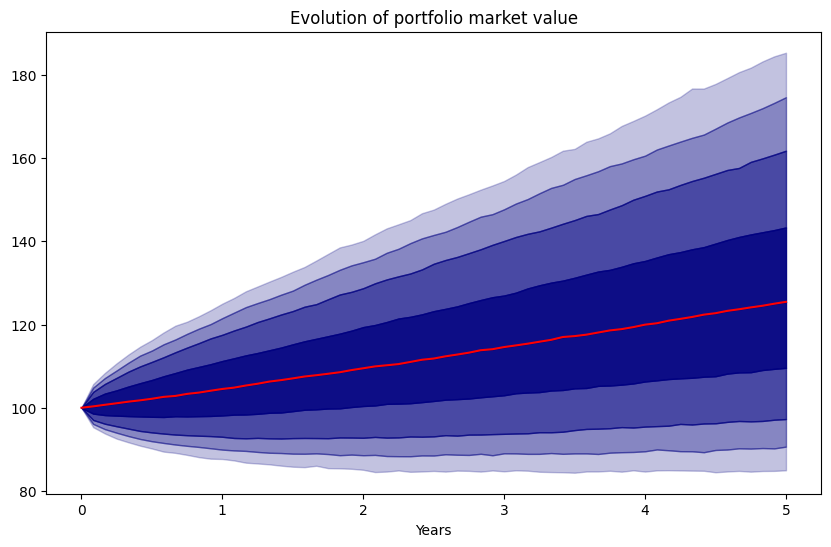

In [75]:
"""
Plot fan chart of zero coupon bond prices
"""
percentiles = np.percentile(port_value / 1e6, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of portfolio market value")
ax.set_xlabel('Years');

## Two investment strategies

In [76]:
"""
Define functions for calculating zero coupon bond prices with spread
"""


def calculate_zero_coupon_yield_with_spread(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float,
                                spread: float): 
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return (a + b * initial_short_rate) / time_to_maturity + spread

def calculate_zero_coupon_price_with_spread(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: float,
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float,
                                spread):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate - spread * time_to_maturity)

In [77]:
tenors_to_plot = np.arange(1.0, 11.0, 1.0)
risk_free_zero_yields = calculate_zero_coupon_yield(tenors_to_plot,
                                                    initial_rate,
                                                    kappa,
                                                    theta,
                                                    beta,
                                                    rp)

risky_zero_yields = calculate_zero_coupon_yield_with_spread(tenors_to_plot,
                                                            initial_rate,
                                                            kappa,
                                                            theta,
                                                            beta,
                                                            rp, 
                                                            300 / 100 / 100)

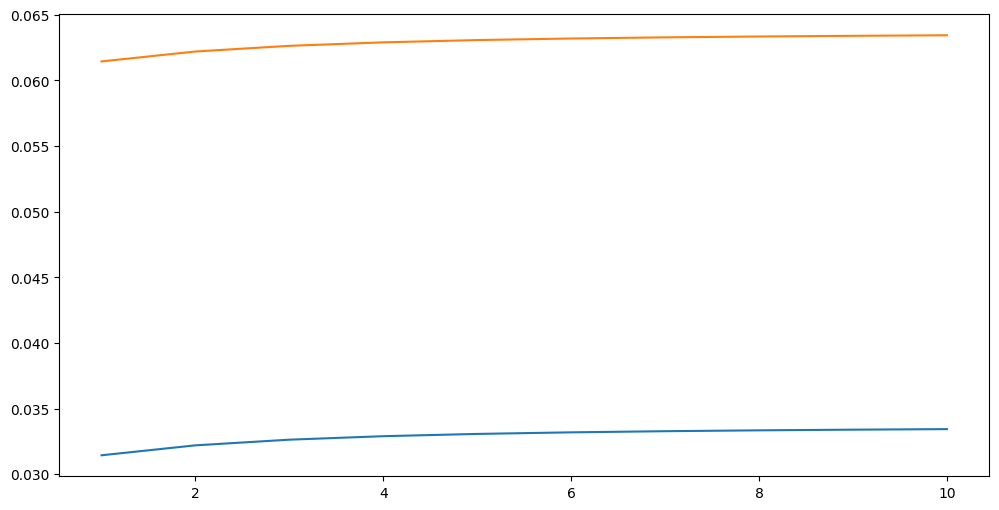

In [78]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(tenors_to_plot, risk_free_zero_yields)
plt.plot(tenors_to_plot, risky_zero_yields);

In [79]:
risky_zero_yields - risk_free_zero_yields

array([0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])

### Expected cash flows at time zero 

The expected value of the equity value for some future time point $T$ at time $t$ is equal to $V_{Eq, t} e^{(T - t) \mu}$. Thus, we have the cash flow as written below.

In [80]:
"""
Define initial expected cash flows
"""

cf_time_points=np.array([1.0, 2.0, 3.0, 4.0, 5.0])
expected_flows_1 = np.array([10.0, 10.0, 10.0, 10.0, 10.0])
expected_flows_2 = np.array([10.0, 10.0, 10.0, 10.0, 10.0])

init_expected_cash_flow_1 = CashFlow(time_points=np.array([1.0, 2.0, 3.0, 4.0, 5.0]), flows=expected_flows_1)
init_expected_cash_flow_2 = CashFlow(time_points=np.array([1.0, 2.0, 3.0, 4.0, 5.0]), flows=expected_flows_2)

In [81]:
"""
Present value
"""

spread = 300 / 100 / 100

discount_factors_t0 = calculate_zero_coupon_price_with_spread(cf_time_points, short_rates[0, 0], kappa, theta, beta, rp, spread)

mv_1 = discount_factors_t0 @ expected_flows_1
mv_2 = discount_factors_t0 @ expected_flows_2

In [82]:
mv_1

41.59296589002812

In [83]:
mv_2

41.59296589002812

In [84]:
"""
Internal rate of return
"""

irr_1 = init_expected_cash_flow_1.internal_rate_of_return(market_value=mv_1)
irr_2 = init_expected_cash_flow_2.internal_rate_of_return(market_value=mv_2)

In [85]:
irr_1

0.062672133507931

In [86]:
irr_2

0.062672133507931

### Realized Cash Flows

In [87]:
week_idx = (cf_time_points / dt).astype(int)

In [88]:
realized_flows_1 = 10 + 5 * (equity_prices[:, week_idx] - np.exp(mu * cf_time_points)[None, :])
realized_flows_2 = 10 - 2.5 * (equity_prices[:, week_idx] - np.exp(mu * cf_time_points)[None, :])

In [89]:
# realized_flows_1

In [90]:
realized_irr_1 = []
realized_irr_2 = []

for s in range(num_sim): 
    
    cf_temp1 = CashFlow(time_points=cf_time_points, flows=realized_flows_1[s, :])
    cf_temp2 = CashFlow(time_points=cf_time_points, flows=realized_flows_2[s, :])
    
    realized_irr_1.append(cf_temp1.internal_rate_of_return(market_value=mv_1, lower_limit= -2.0, upper_limit= 2.0))
    realized_irr_2.append(cf_temp2.internal_rate_of_return(market_value=mv_2, lower_limit= -2.0, upper_limit= 2.0))

realized_irr_1 = np.array(realized_irr_1)
realized_irr_2 = np.array(realized_irr_2)

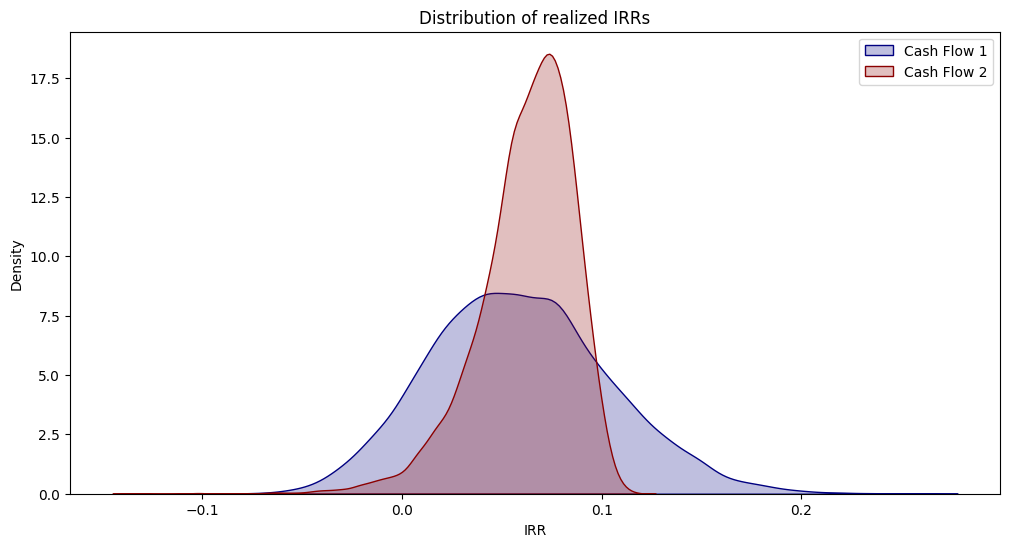

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(realized_irr_1, fill=True, color='navy', ax=ax, label="Cash Flow 1")
sns.kdeplot(realized_irr_2, fill=True, color='darkred', ax=ax, label="Cash Flow 2")

ax.set_title('Distribution of realized IRRs')
ax.set_xlabel('IRR')

ax.legend();

### Portfolio effect

In [92]:

realized_mv_1 = np.zeros((num_sim, len(time_points)))
realized_mv_1[:, 0] = mv_1

realized_mv_2 = np.zeros((num_sim, len(time_points)))
realized_mv_2[:, 0] = mv_1

In [93]:
def calculate_zero_coupon_price_with_spread_vectorized(time_to_maturity: Union[float, np.ndarray],
                                initial_short_rate: Union[float, np.ndarray],
                                kappa: float,
                                theta: float,
                                beta: float,
                                risk_premium: float,
                                spread):
    
    y_infty = theta - risk_premium * beta / kappa - beta**2 / (2 * kappa**2)
    
    b = 1 / kappa * (1 - np.exp(-kappa * time_to_maturity))
    a = y_infty * (time_to_maturity  - b) + beta**2 / (4 * kappa) * b**2
    
    return np.exp(- a - b * initial_short_rate[:, None] - spread * time_to_maturity)

In [94]:
"""
Calculate market value of future expected cash flows
"""

expectation_equity = np.exp(mu * cf_time_points)

for i, t in enumerate(time_points[:-1]): 
    # indicator to select cash flow and time points
    adj_cf_time_points = (cf_time_points - t)
    indicator = adj_cf_time_points > 0

    # adjusted time points
    adj_cf_time_points = adj_cf_time_points[indicator]

    # relevant initial equity expectations
    adj_init_expectation_equity = expectation_equity[indicator]
    
    # expected future cash flow
    expected_future_cash_flow_1 = 10 + 5 * (np.outer(equity_prices[:, i], np.exp(mu * adj_cf_time_points)) - adj_init_expectation_equity[None, :])
    expected_future_cash_flow_2 = 10 - 2.5 * (np.outer(equity_prices[:, i], np.exp(mu * adj_cf_time_points)) - adj_init_expectation_equity[None, :])
        
    # calculate discount vectors
    discount_vectors = calculate_zero_coupon_price_with_spread_vectorized(adj_cf_time_points, short_rates[:, i], kappa, theta, beta, rp, spread)

    # calculate market values
    realized_mv_1[:, i] = np.sum(discount_vectors * expected_future_cash_flow_1, axis=1)
    realized_mv_2[:, i] = np.sum(discount_vectors * expected_future_cash_flow_2, axis=1)

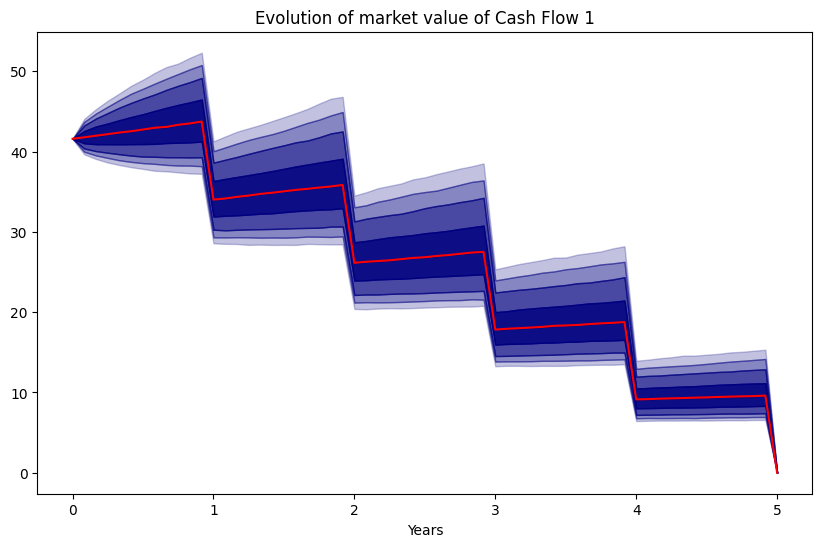

In [95]:
"""
Plot fan chart of cash flow market values
"""
percentiles = np.percentile(realized_mv_1, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of market value of Cash Flow 1")
ax.set_xlabel('Years');

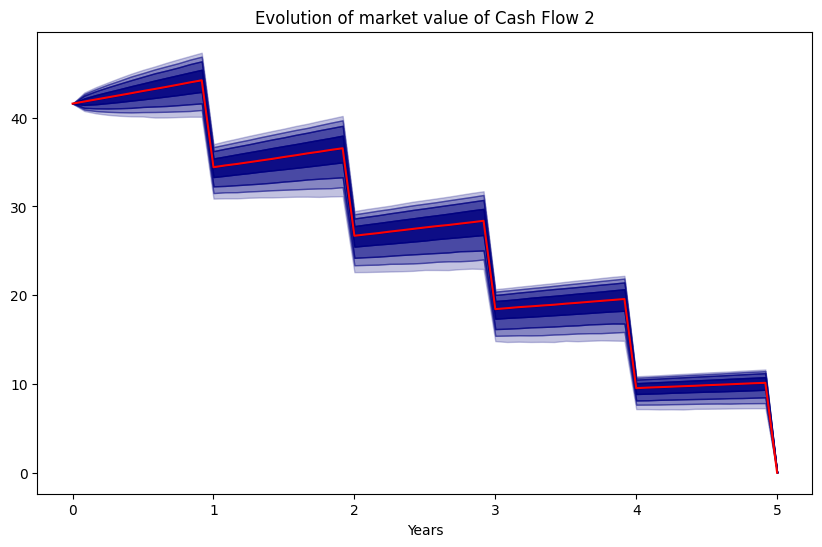

In [96]:
"""
Plot fan chart of cash flow market values
"""
percentiles = np.percentile(realized_mv_2, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of market value of Cash Flow 2")
ax.set_xlabel('Years');

In [97]:
"""
Simulate value of portfolio with the two different investments
"""

'\nSimulate value of portfolio with the two different investments\n'

In [98]:
port_value_1 = np.zeros((num_sim, len(time_points)))
port_value_1[:, 0] = init_wealth / 1e6

asset_value_1 = np.zeros((num_sim, len(time_points)))
asset_value_1[:, 0] = port_value_1[:, 0] - realized_mv_1[:, 0]

port_value_2 = np.zeros((num_sim, len(time_points)))
port_value_2[:, 0] = init_wealth / 1e6

asset_value_2 = np.zeros((num_sim, len(time_points)))
asset_value_2[:, 0] = port_value_2[:, 0] - realized_mv_2[:, 0]

idx = 0
for i, t in enumerate(time_points[1:], start=1): 

    asset_value_1[:, i] = asset_value_1[:, i - 1] * (1 + port_ret[:, i - 1])
    asset_value_2[:, i] = asset_value_2[:, i - 1] * (1 + port_ret[:, i - 1])

    if i in week_idx: 

        asset_value_1[:, i] += realized_flows_1[:, idx]
        asset_value_2[:, i] += realized_flows_2[:, idx]

        idx += 1

    port_value_1[:, i] = asset_value_1[:, i] + realized_mv_1[:, i]
    port_value_2[:, i] = asset_value_2[:, i] + realized_mv_2[:, i]
    

In [99]:
port_value_scaled = port_value / 1e6

array([12, 24, 36, 48, 60])

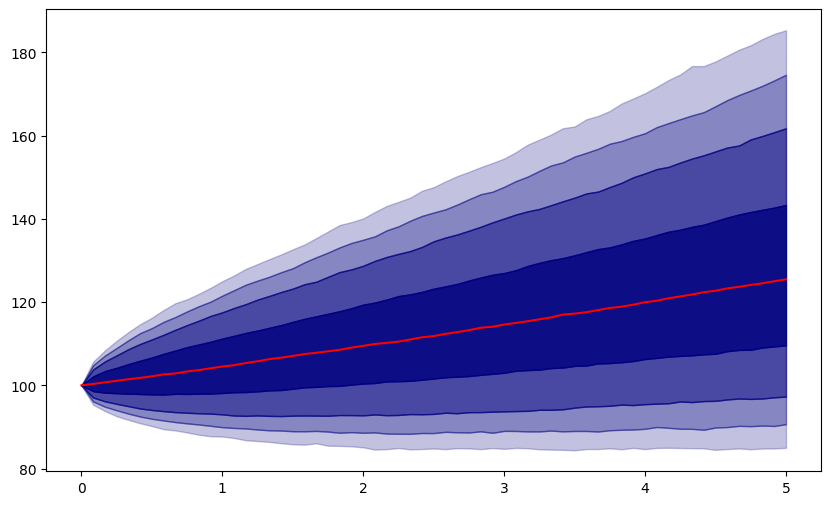

In [100]:
"""
Plot fan chart of initial portfolio
"""
percentiles = np.percentile(port_value_scaled, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

week_idx

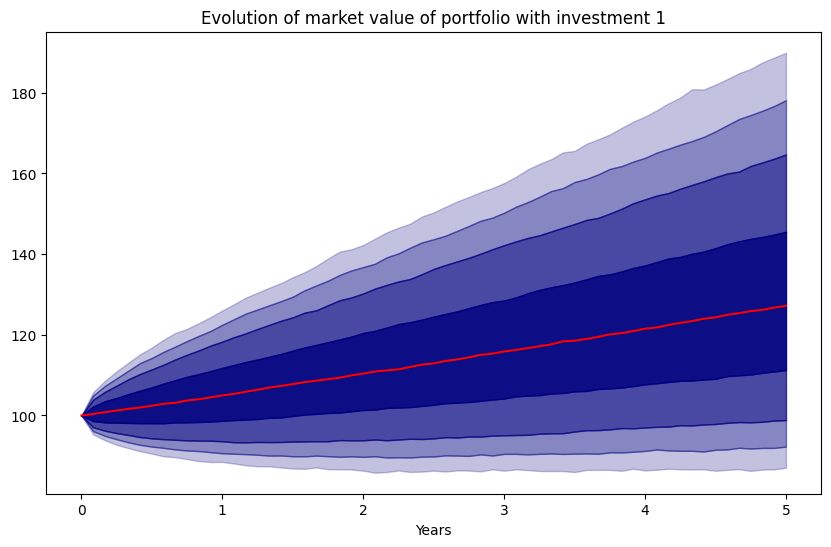

In [101]:
"""
Plot fan chart of portfolio with investment 1
"""
percentiles = np.percentile(port_value_1, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of market value of portfolio with investment 1")
ax.set_xlabel('Years');

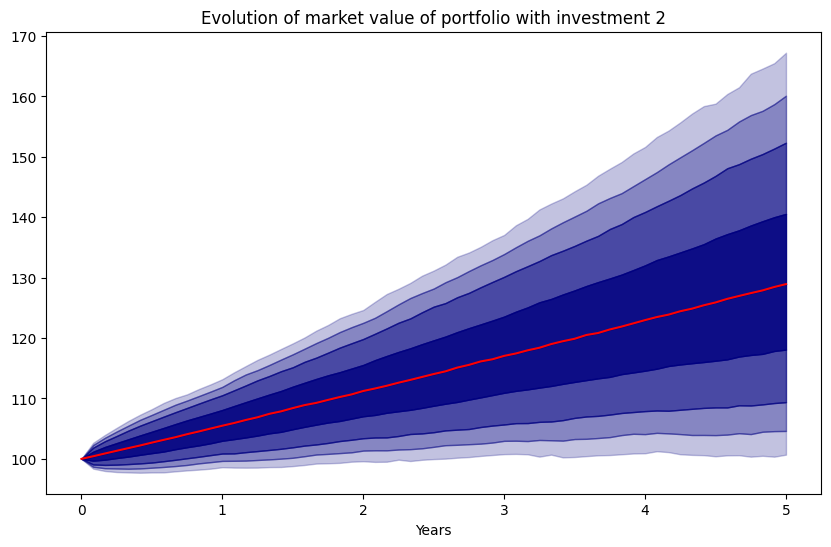

In [102]:
"""
Plot fan chart of portfolio with investment 2
"""
percentiles = np.percentile(port_value_2, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
fan_chart(time_points, percentiles, ax=ax, color="navy")

ax.set_title("Evolution of market value of portfolio with investment 2")
ax.set_xlabel('Years');

### Evaluation

A quick evaluation of the strategies is presented below. A good solution will also look at the risk during the investment period, distribution of realized Sharpe ratios, etc. 

In [103]:
df_eval = pd.DataFrame(index=['Expectation', 'Std.', 'CVaR(5%)'], columns=['Initial portfolio', 'Investment 1', 'Investment 2'], 
                       data = np.array([[np.mean(port_value_scaled[:, -1]), np.mean(port_value_1[:, -1]), np.mean(port_value_2[:, -1])], 
                                        [np.std(port_value_scaled[:, -1]), np.std(port_value_1[:, -1]), np.std(port_value_2[:, -1])], 
                                        [rm.calculate_conditional_value_at_risk(port_value_scaled[:, -1] - init_wealth / 1e6, p=0.05), rm.calculate_conditional_value_at_risk(port_value_1[:, -1] - init_wealth / 1e6, p=0.05), rm.calculate_conditional_value_at_risk(port_value_2[:, -1] - init_wealth / 1e6, p=0.05)]]))


In [104]:
df_eval

,Initial portfolio,Investment 1,Investment 2
Expectation,128.009734,130.074045,130.154482
Std.,25.776948,26.454157,17.008638
CVaR(5%),-16.239602,-14.413757,-0.476768


Clearly, investment 2 seems to be the most attractive.